# Forest fire

In [194]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from collections.abc import Iterable
from functools import cached_property

In [185]:
class ClusterCounter:
    
    def __init__(self, env):
        self.burnt_env = np.zeros((env.shape[0]+2, env.shape[1]+2), dtype=int)
        self.burnt_env[1:-1, 1:-1] = (env.copy()==3)
        self.max_label = 0
        self.label = np.zeros(self.burnt_env.shape, dtype=int)
        self.labels = np.arange(env.size, dtype=int)

    def get_label(self, x):
        y = x
        while self.labels[y] != y:
            y = self.labels[y]
        while self.labels[x] != x:
            z = self.labels[x]
            self.labels[x] = y
            x = z
        return y

    def union_labels(self, tags):
        tags = np.sort(tags)
        min_tag = tags[0]
        for tag in tags[1:]:
            self.labels[self.get_label(tag)] = self.get_label(min_tag)

    def find_clusters(self):
        for i in range(self.burnt_env.shape[0]):
            for j in range(self.burnt_env.shape[1]):
                if self.burnt_env[i,j]>0:
                    l = self.label[i, j-1]
                    t = self.label[i-1, j]
                    tl = self.label[i-1, j-1]
                    tr = self.label[i-1, j+1]
                    if l+t+tl+tr == 0:
                        self.max_label += 1 #new label coz no neibhours have one
                        self.label[i,j] = self.max_label
                    elif (l>0) and (t+tl+tr == 0):
                        self.label[i,j] = self.get_label(l)
                    elif (t>0) and (l+tl+tr == 0):
                        self.label[i,j] = self.get_label(t)
                    elif (tl>0) and (l+t+tl+tr == 0):
                        self.label[i,j] = self.get_label(tl)
                    elif (tr>0) and (l+t+tl == 0):
                        self.label[i,j] = self.get_label(tr)
                    else:
                        filled_neigh = list(filter(lambda x: x>0, [l,t,tl,tr]))
                        self.union_labels(filled_neigh)
                        self.label[i,j] = self.get_label(filled_neigh[0])
        map_clusters = np.vectorize(lambda x: self.get_label(x))
        self.label = map_clusters(self.label)
        return self.label[1:-1, 1:-1]
    
    def find_max_cluster(self):
        clusters = self.find_clusters().ravel()
        if clusters.sum() == 0:
            return 0
        non_empty = list(filter(lambda x: x>0, clusters))
        _, counts = np.unique(non_empty, return_counts=True)
        return max(counts)
        

In [186]:
class ForestFire:

    def __init__(self, L: int, p: float):
        self.L = L
        self.p = p
        self.gen_env()

    def gen_env(self):
        env = np.random.choice([0,1], (self.L,self.L), p=[1-self.p, self.p])
        env[:,0] = 2 * env[:,0]
        self.env = env.copy()

    def get_neigh(self, x: int, y: int):
        neigh_border = np.array([max(0, x-1),min(self.L, x+2), max(0, y-1), min(self.L, y+2)])
        return neigh_border

    def update(self):
        base_env = self.env.copy()
        x,y = np.where(base_env==2)
        for i in range(len(x)):
            x_min, x_max, y_min, y_max = self.get_neigh(x[i], y[i])
            self.env[x_min:x_max, y_min:y_max] = base_env[x_min:x_max, y_min:y_max] + (base_env[x_min:x_max, y_min:y_max]==1)
        self.env += (base_env == 2)

    def sim(self):
        while np.where(self.env==2)[0].size > 0:
            self.update()

    def get_full_sim(self):
        full_states = [self.env.copy()]
        while np.where(self.env==2)[0].size > 0:
            self.update()
            full_states.append(self.env.copy())
        return full_states

def run_forest_fire(Ls: Iterable, ps: Iterable, M: int):
    mt = np.zeros((len(Ls),len(ps)))
    clusters = np.zeros((len(Ls),len(ps)))
    for n in range(len(Ls)):
        ms = []
        cs = []
        for p in ps:
            m = 0
            c = 0
            for i in range(M):
                forest = ForestFire(L=Ls[n], p=p)
                forest.sim()
                m += 1 if sum(forest.env[:,-1]==3) > 0 else 0
                c += ClusterCounter(forest.env).find_max_cluster()
            cs.append(c/M)
            ms.append(m/M)
        mt[n,:] = ms
        clusters[n,:] = cs

    return mt, clusters

In [195]:
L = 100 #one dim size, so matrix (L,L)
p=0.4 #density, probability of a space being populated with a tree
base_env = ForestFire(L, p).env

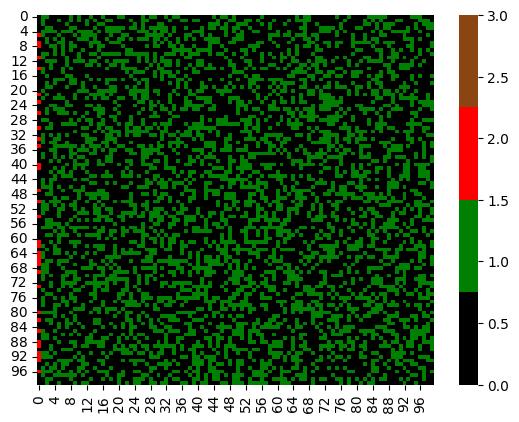

In [197]:
sns.heatmap(base_env, vmin=0, vmax=3, cmap=['black', 'green', 'red', 'saddlebrown'])
plt.show()

$L=20$

In [174]:
sample_env_burn = ForestFire(L=20, p=0.5).get_full_sim()
sample_env_safe = ForestFire(L=20, p=0.2).get_full_sim()

In [175]:
def make_animation(state, step):
    plt.clf()  
    plt.title(f"State at {step} MCS")
    sns.heatmap(state, vmin=0, vmax=3, cmap=['black', 'green', 'red', 'saddlebrown'])
    return plt

In [176]:
def animate(step):
    make_animation(sample_env_burn[step], step)

fig = plt.figure()
anim = FuncAnimation(fig, animate, frames=len(sample_env_burn), interval=1, repeat=False)
anim.save("states_20_burn.gif")
plt.close(fig)

In [177]:
def animate(step):
    make_animation(sample_env_safe[step], step)

fig = plt.figure()
anim = FuncAnimation(fig, animate, frames=len(sample_env_safe), interval=1, repeat=False)
anim.save("states_20_safe.gif")
plt.close(fig)

$L=100$

In [178]:
sample_env_burn100 = ForestFire(L=100, p=0.5).get_full_sim()
sample_env_safe100 = ForestFire(L=100, p=0.2).get_full_sim()

In [179]:
def animate(step):
    make_animation(sample_env_burn100[step], step)

fig = plt.figure()
anim = FuncAnimation(fig, animate, frames=len(sample_env_burn100), interval=1, repeat=False)
anim.save("states_100_burn.gif")
plt.close(fig)

In [180]:
def animate(step):
    make_animation(sample_env_safe100[step], step)

fig = plt.figure()
anim = FuncAnimation(fig, animate, frames=len(sample_env_safe100), interval=1, repeat=False)
anim.save("states_100_safe.gif")
plt.close(fig)

## Monte Carlo simulation 

In [187]:
M=100
Ls = [20,50,100]
ps = np.arange(0,1.01,0.01)
mt, clusters = run_forest_fire(Ls, ps, M)

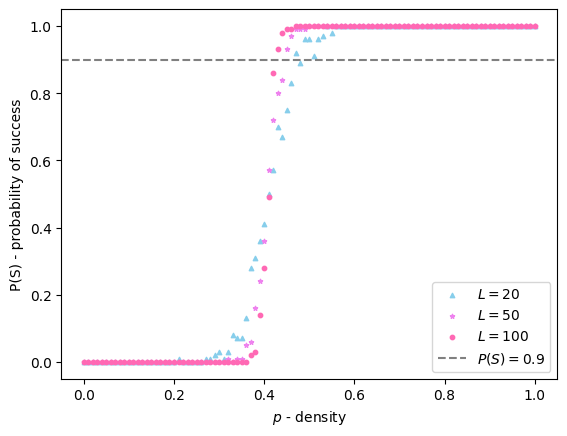

In [189]:
marker_dict = {20: '^',
               50: '*',
               100: 'o'}
color_dict = {20: 'skyblue',
              50: 'violet',
              100: 'hotpink'}

for n in range(len(Ls)):
    plt.scatter(ps, 
                mt[n,:], 
                marker=marker_dict[Ls[n]], 
                s=10, 
                c = color_dict[Ls[n]], 
                label = f'$L={Ls[n]}$')
plt.axhline(y=0.9, linestyle='--', color='gray', label='$P(S)=0.9$')
plt.xlabel('$p$ - density')
plt.ylabel('P(S) - probability of success')
plt.legend()
plt.show()

In [222]:
for i in range(3):
    pq = ps[np.where(np.asarray(mt[i,:])>0.9)[0][0]]
    print(f'With L={Ls[i]} for p*={pq}, P(S) exceeds 0.9')

With L=20 for p*=0.47000000000000003, P(S) exceeds 0.9
With L=50 for p*=0.45, P(S) exceeds 0.9
With L=100 for p*=0.43, P(S) exceeds 0.9


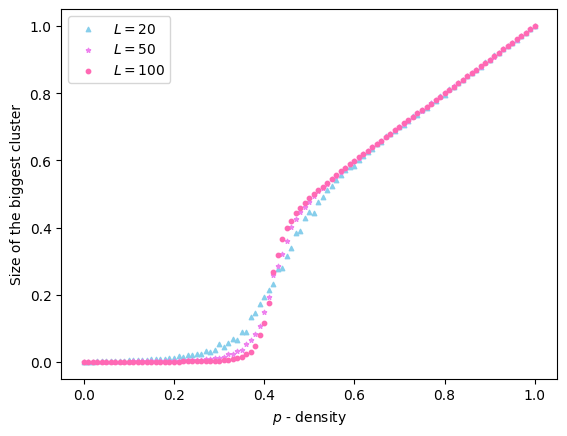

In [191]:
for n in range(len(Ls)):
    plt.scatter(ps, 
                list(map(lambda x: x/(Ls[n]**2), clusters[n,:])), 
                marker=marker_dict[Ls[n]], 
                s=10, 
                c = color_dict[Ls[n]], 
                label = f'$L={Ls[n]}$')
plt.xlabel('$p$ - density')
plt.ylabel('Size of the biggest cluster')
plt.legend()
plt.show()

In [208]:
class ForestFireWind(ForestFire):

    def __init__(self, L: int, p: float, w_dir: str, w_pow: int):
        super().__init__(L = L, p = p)
        self.w_dir = w_dir
        self.w_pow = w_pow

    @cached_property
    def neigh_with_wind(self):
        name_dict = {
            'top': lambda x,y: np.array([max(0, x-1 - self.w_pow), min(self.L, x+2), max(0, y-1), min(self.L, y+2)]),
            'bottom': lambda x,y: np.array([max(0, x-1), min(self.L, x+2 + self.w_pow), max(0, y-1), min(self.L, y+2)]),
            'right': lambda x,y: np.array([max(0, x-1), min(self.L, x+2), max(0, y-1), min(self.L, y+2 + self.w_pow)]),
            'left': lambda x,y: np.array([max(0, x-1), min(self.L, x+2), max(0, y-1 - self.w_pow), min(self.L, y+2)]),
        }
        return name_dict.get(self.w_dir)
    
    def get_neigh(self, x: int, y: int):
        neigh_border = self.neigh_with_wind(x, y)
        return neigh_border

def run_forest_fire_wind(L, ps, M, w_dir, w_pows):
    mt = np.zeros((len(w_pows),len(ps)))
    clusters = np.zeros((len(w_pows),len(ps)))
    for n in range(len(w_pows)):
        ms = []
        cs = []
        for p in ps:
            m = 0
            c = 0
            for i in range(M):
                forest = ForestFireWind(L=L, p=p, w_dir = w_dir, w_pow = w_pows[n])
                forest.sim()
                m += 1 if sum(forest.env[:,-1]==3) > 0 else 0
                c += ClusterCounter(forest.env).find_max_cluster()
            cs.append(c/M)
            ms.append(m/M)
        mt[n,:] = ms
        clusters[n,:] = cs

    return mt, clusters

In [209]:
M=100
L=100
ps = np.arange(0,1.01,0.01)
w_pows = range(4)
mt_w, clusters_w = run_forest_fire_wind(L=L, ps=ps, M=M, w_dir='right', w_pows=w_pows)

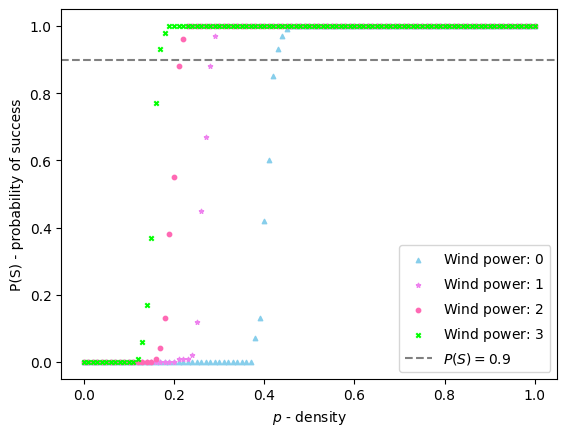

In [213]:

color_dict_w = {0: 'skyblue',
                1: 'violet',
                2: 'hotpink',
                3: 'lime'}
marker_dict_w = {0: '^',
                 1: '*',
                 2: 'o',
                 3: 'x'}
for n in range(len(w_pows)):
    plt.scatter(ps, 
                mt_w[n,:], 
                marker=marker_dict_w[w_pows[n]], 
                s=10, 
                c = color_dict_w[w_pows[n]], 
                label = f'Wind power: ${w_pows[n]}$')
plt.axhline(y=0.9, linestyle='--', color='gray', label='$P(S)=0.9$')
plt.xlabel('$p$ - density')
plt.ylabel('P(S) - probability of success')
plt.legend()
plt.show()

In [221]:
for i in range(len(w_pows)):
    pq = ps[np.where(np.asarray(mt_w[i,:])>0.9)[0][0]]
    print(f'With wind power: {w_pows[i]} for p*={pq}, P(S) exceeds 0.9')

With wind power: 0 for p*=0.43, P(S) exceeds 0.9
With wind power: 1 for p*=0.29, P(S) exceeds 0.9
With wind power: 2 for p*=0.22, P(S) exceeds 0.9
With wind power: 3 for p*=0.17, P(S) exceeds 0.9


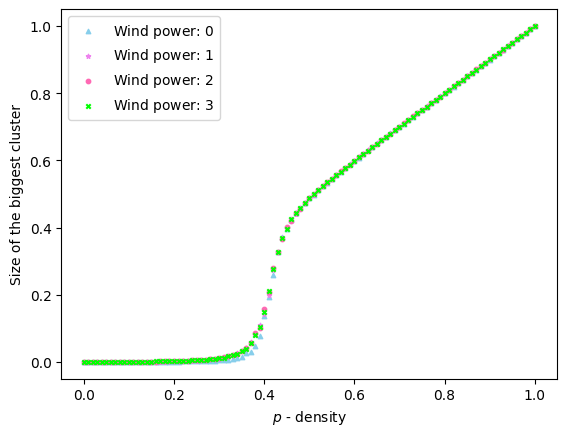

In [244]:

for n in range(len(w_pows)):
    plt.scatter(ps, 
                clusters_w[n,:]/L**2, 
                marker=marker_dict_w[w_pows[n]], 
                s=10, 
                c = color_dict_w[w_pows[n]], 
                label = f'Wind power: ${w_pows[n]}$')
plt.xlabel('$p$ - density')
plt.ylabel('Size of the biggest cluster')
plt.legend()
plt.show()

In [228]:
M=100
L=100
ps = np.arange(0,1.01,0.01)
w_pows = range(4)
mt_wt, clusters_wt = run_forest_fire_wind(L=L, ps=ps, M=M, w_dir='top', w_pows=w_pows)

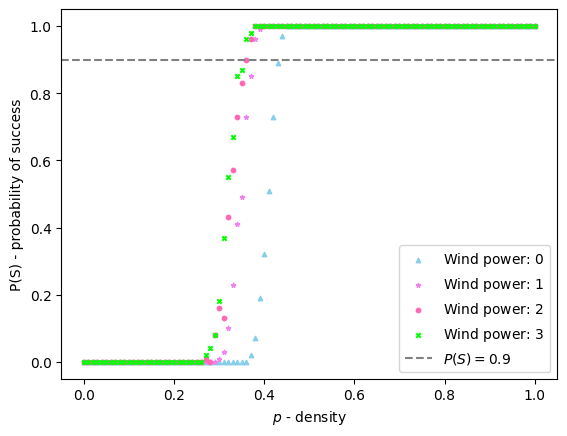

In [229]:
for n in range(len(w_pows)):
    plt.scatter(ps, 
                mt_wt[n,:], 
                marker=marker_dict_w[w_pows[n]], 
                s=10, 
                c = color_dict_w[w_pows[n]], 
                label = f'Wind power: ${w_pows[n]}$')
plt.axhline(y=0.9, linestyle='--', color='gray', label='$P(S)=0.9$')
plt.xlabel('$p$ - density')
plt.ylabel('P(S) - probability of success')
plt.legend()
plt.show()

In [230]:
for i in range(len(w_pows)):
    pq = ps[np.where(np.asarray(mt_wt[i,:])>0.9)[0][0]]
    print(f'With wind power: {w_pows[i]} for p*={pq}, P(S) exceeds 0.9')

With wind power: 0 for p*=0.44, P(S) exceeds 0.9
With wind power: 1 for p*=0.38, P(S) exceeds 0.9
With wind power: 2 for p*=0.37, P(S) exceeds 0.9
With wind power: 3 for p*=0.36, P(S) exceeds 0.9


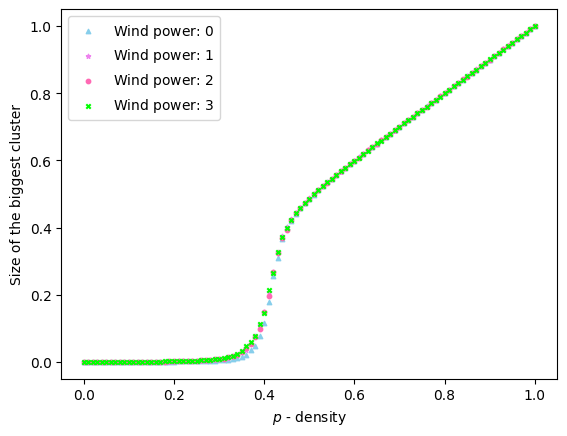

In [231]:
for n in range(len(w_pows)):
    plt.scatter(ps, 
                clusters_wt[n,:]/L**2, 
                marker=marker_dict_w[w_pows[n]], 
                s=10, 
                c = color_dict_w[w_pows[n]], 
                label = f'Wind power: ${w_pows[n]}$')
plt.xlabel('$p$ - density')
plt.ylabel('Size of the biggest cluster')
plt.legend()
plt.show()

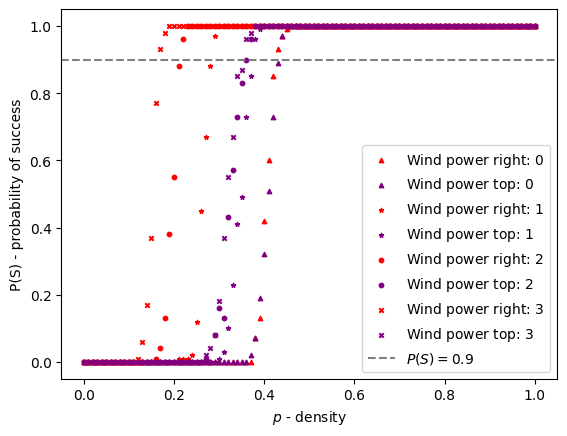

In [245]:
for n in range(len(w_pows)):
    plt.scatter(ps, 
                mt_w[n,:], 
                marker=marker_dict_w[w_pows[n]], 
                s=10, 
                c = 'red', 
                label = f'Wind power right: ${w_pows[n]}$')
    plt.scatter(ps, 
                mt_wt[n,:], 
                marker=marker_dict_w[w_pows[n]], 
                s=10, 
                c = 'purple', 
                label = f'Wind power top: ${w_pows[n]}$')
plt.axhline(y=0.9, linestyle='--', color='gray', label='$P(S)=0.9$')
plt.xlabel('$p$ - density')
plt.ylabel('P(S) - probability of success')
plt.legend()
plt.show()

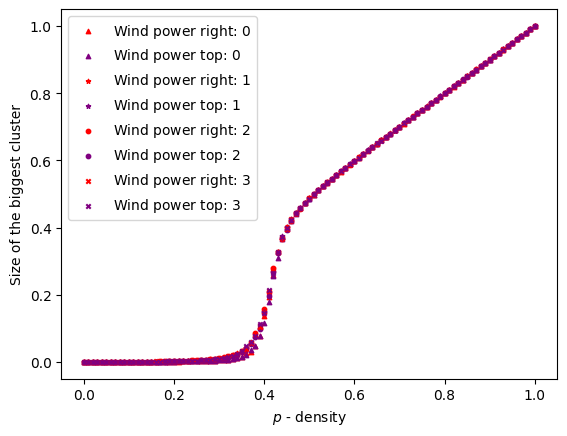

In [235]:
for n in range(len(w_pows)):
    plt.scatter(ps, 
                clusters_w[n,:]/L**2, 
                marker=marker_dict_w[w_pows[n]], 
                s=10, 
                c = 'red', 
                label = f'Wind power right: ${w_pows[n]}$')
    plt.scatter(ps, 
                clusters_wt[n,:]/L**2, 
                marker=marker_dict_w[w_pows[n]], 
                s=10, 
                c = 'purple', 
                label = f'Wind power top: ${w_pows[n]}$')
plt.xlabel('$p$ - density')
plt.ylabel('Size of the biggest cluster')
plt.legend()
plt.show()

In [236]:
sample_env_burn_wind_right_1 = ForestFireWind(L=100, p=0.5, w_dir = 'right', w_pow = 1).get_full_sim()
sample_env_burn_wind_right_2 = ForestFireWind(L=100, p=0.5, w_dir = 'right', w_pow = 2).get_full_sim()
sample_env_burn_wind_right_3 = ForestFireWind(L=100, p=0.5, w_dir = 'right', w_pow = 3).get_full_sim()

sample_env_burn_wind_top_1 = ForestFireWind(L=100, p=0.5, w_dir = 'top', w_pow = 1).get_full_sim()
sample_env_burn_wind_top_2 = ForestFireWind(L=100, p=0.5, w_dir = 'top', w_pow = 2).get_full_sim()
sample_env_burn_wind_top_3 = ForestFireWind(L=100, p=0.5, w_dir = 'top', w_pow = 3).get_full_sim()

In [237]:
def animate(step):
    make_animation(sample_env_burn_wind_right_1[step], step)

fig = plt.figure()
anim = FuncAnimation(fig, animate, frames=len(sample_env_burn_wind_right_1), interval=1, repeat=False)
anim.save("states_100_burn_wind_right_1.gif")
plt.close(fig)

In [238]:
def animate(step):
    make_animation(sample_env_burn_wind_right_2[step], step)

fig = plt.figure()
anim = FuncAnimation(fig, animate, frames=len(sample_env_burn_wind_right_2), interval=1, repeat=False)
anim.save("states_100_burn_wind_right_2.gif")
plt.close(fig)

In [239]:
def animate(step):
    make_animation(sample_env_burn_wind_right_3[step], step)

fig = plt.figure()
anim = FuncAnimation(fig, animate, frames=len(sample_env_burn_wind_right_3), interval=1, repeat=False)
anim.save("states_100_burn_wind_right_3.gif")
plt.close(fig)

In [240]:
def animate(step):
    make_animation(sample_env_burn_wind_top_1[step], step)

fig = plt.figure()
anim = FuncAnimation(fig, animate, frames=len(sample_env_burn_wind_top_1), interval=1, repeat=False)
anim.save("states_100_burn_wind_top_1.gif")
plt.close(fig)

In [241]:
def animate(step):
    make_animation(sample_env_burn_wind_top_2[step], step)

fig = plt.figure()
anim = FuncAnimation(fig, animate, frames=len(sample_env_burn_wind_top_2), interval=1, repeat=False)
anim.save("states_100_burn_wind_top_2.gif")
plt.close(fig)

In [242]:
def animate(step):
    make_animation(sample_env_burn_wind_top_3[step], step)

fig = plt.figure()
anim = FuncAnimation(fig, animate, frames=len(sample_env_burn_wind_top_3), interval=1, repeat=False)
anim.save("states_100_burn_wind_top_3.gif")
plt.close(fig)